In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

we are currently using tensorflow version 2.10.0


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Setting up an environment</h1>

In [2]:
TRAIN_DIR = 'C:\\Users\\HP\\Desktop\\project\\Code\\Training all models\\RiceLeafsDisease\\train'
TEST_DIR = 'C:\\Users\\HP\\Desktop\\project\\Code\\Training all models\\RiceLeafsDisease\\validation'
val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 42
im_shape = (250,250)

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Data Processing</h1>

In [4]:
# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,vertical_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,vertical_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255)


# Generator of Train
train_generator = data_generator.flow_from_directory(TRAIN_DIR, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(TRAIN_DIR, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">CNN Architecture</h1>

In [2]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

for layer in base_model.layers:
    layer.trainable=False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_94 (Bat  (None, 6, 6, 2048)       8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 23,915,302
Trainable params: 2,108,422
Non

In [7]:
# compiling model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
import time
start_time = time.time()

In [9]:
# Train the model
epochs = 10

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='InceptionV3_DA.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(train_generator, epochs=epochs, callbacks = callbacks_list, validation_data=validation_generator)


Epoch 1/10
53/53 [==============================] - ETA: 0s - loss: 1.3780 - accuracy: 0.4685
Epoch 1: val_loss improved from inf to 1.56914, saving model to InceptionV3_DA.h5
53/53 [==============================] - 105s 2s/step - loss: 1.3780 - accuracy: 0.4685 - val_loss: 1.5691 - val_accuracy: 0.4048
Epoch 2/10
53/53 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.6929
Epoch 2: val_loss improved from 1.56914 to 0.86245, saving model to InceptionV3_DA.h5
53/53 [==============================] - 76s 1s/step - loss: 0.8355 - accuracy: 0.6929 - val_loss: 0.8625 - val_accuracy: 0.6548
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.7702
Epoch 3: val_loss did not improve from 0.86245
53/53 [==============================] - 75s 1s/step - loss: 0.6385 - accuracy: 0.7702 - val_loss: 0.8687 - val_accuracy: 0.6333
Epoch 4/10
53/53 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7738
Epoch 4: val_loss did

In [10]:
# Record the training end time
end_time = time.time()

In [11]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 790.4829180240631 seconds


In [12]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.378027,0.468452,1.569139,0.404762
1,0.835498,0.692857,0.862454,0.654762
2,0.638539,0.770238,0.868730,0.633333
3,0.565105,0.773810,0.949941,0.657143
4,0.478563,0.826190,0.878408,0.680952
5,0.433038,0.842262,1.095925,0.630952
6,0.409875,0.860714,0.556235,0.780952
7,0.334437,0.879167,0.555160,0.821429
8,0.319422,0.886310,0.646247,0.771429
9,0.312698,0.885714,0.560316,0.807143


In [14]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

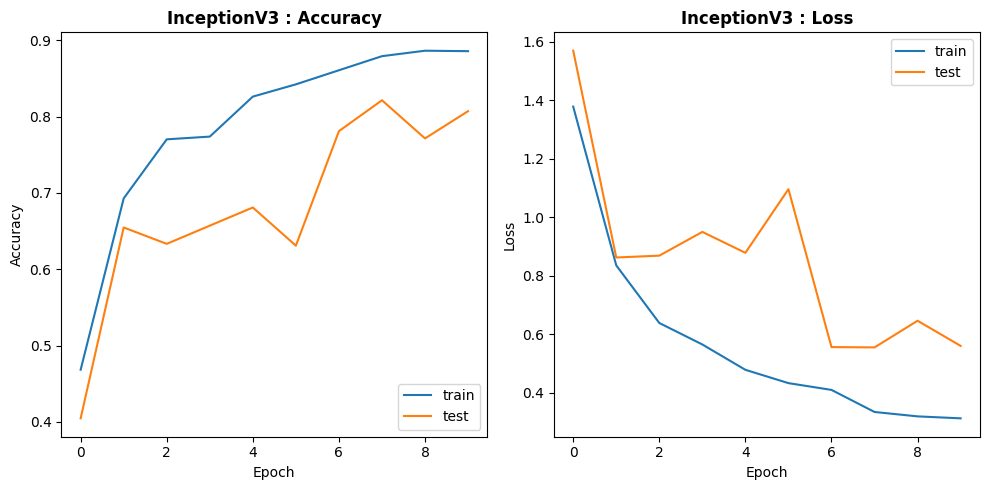

In [15]:
plot_performance(model_name= 'InceptionV3',
                 acc=history.history['accuracy'], 
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'], 
                 val_loss=history.history['val_loss'])

In [16]:
import joblib

joblib.dump(history.history,'history_InceptionV3_DA.pkl')
history = joblib.load('history_InceptionV3_DA.pkl')

## 性能评估

In [17]:
# Load the best saved model
from keras.models import load_model

model = load_model('InceptionV3_DA.h5')
score = model.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

14/14 [==============================] - 16s 1s/step - loss: 0.6484 - accuracy: 0.7976

Val loss: 0.6483698487281799
Val accuracy: 0.7976190447807312
17/17 [==============================] - 19s 1s/step - loss: 0.6791 - accuracy: 0.7841

Test loss: 0.6790988445281982
Test accuracy: 0.7840909361839294


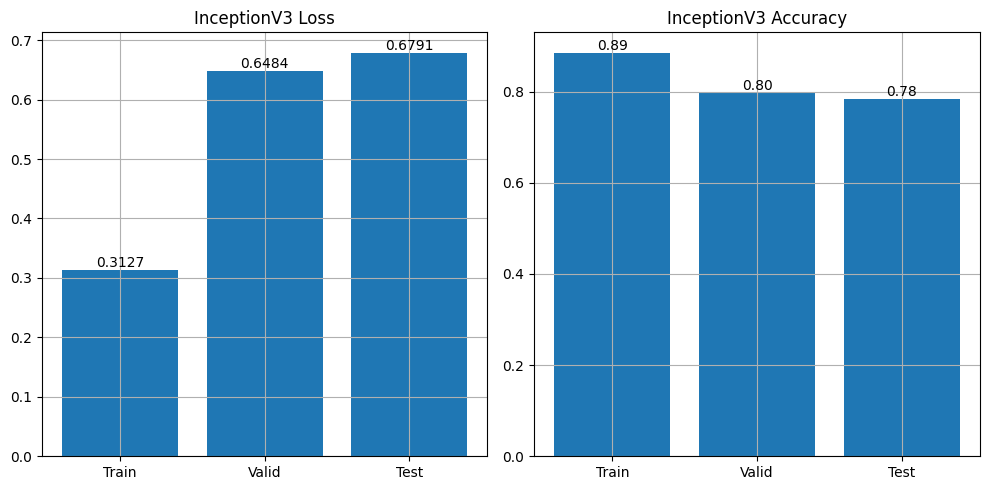

In [19]:
# Visualizing Model Performance
# 要改数据：
loss_values = [0.312698, 0.6483698487281799, 0.6790988445281982]  
accuracy_values = [0.885714, 0.7976190447807312, 0.7840909361839294] 

plt.figure(figsize=(10, 5))  
  
# 第一个子图：模型损失  
plt.subplot(1, 2, 1)  
plt.title("InceptionV3 Loss")  
plt.bar(["Train", "Valid", "Test"], loss_values)  
  
# 为模型损失的每个条形添加数字标签  
for index, value in enumerate(loss_values):  
    plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')  
  
plt.grid()  
  
# 第二个子图：模型准确率  
plt.subplot(1, 2, 2)  
plt.title("InceptionV3 Accuracy")  
plt.bar(["Train", "Valid", "Test"], accuracy_values)  
  
# 为模型准确率的每个条形添加数字标签  
for index, value in enumerate(accuracy_values):  
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')  
  
plt.grid()  
  
# 显示图表  
plt.tight_layout()  # 确保子图之间不会重叠  
plt.show()

In [20]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

17/17 [==============================] - 19s 1s/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.65      1.00      0.79        88
           brown_spot       0.78      0.61      0.69        88
              healthy       0.74      0.94      0.83        88
           leaf_blast       0.91      0.47      0.62        88
           leaf_scald       0.97      0.83      0.90        88
    narrow_brown_spot       0.82      0.85      0.84        88

             accuracy                           0.78       528
            macro avg       0.81      0.78      0.78       528
         weighted avg       0.81      0.78      0.78       528



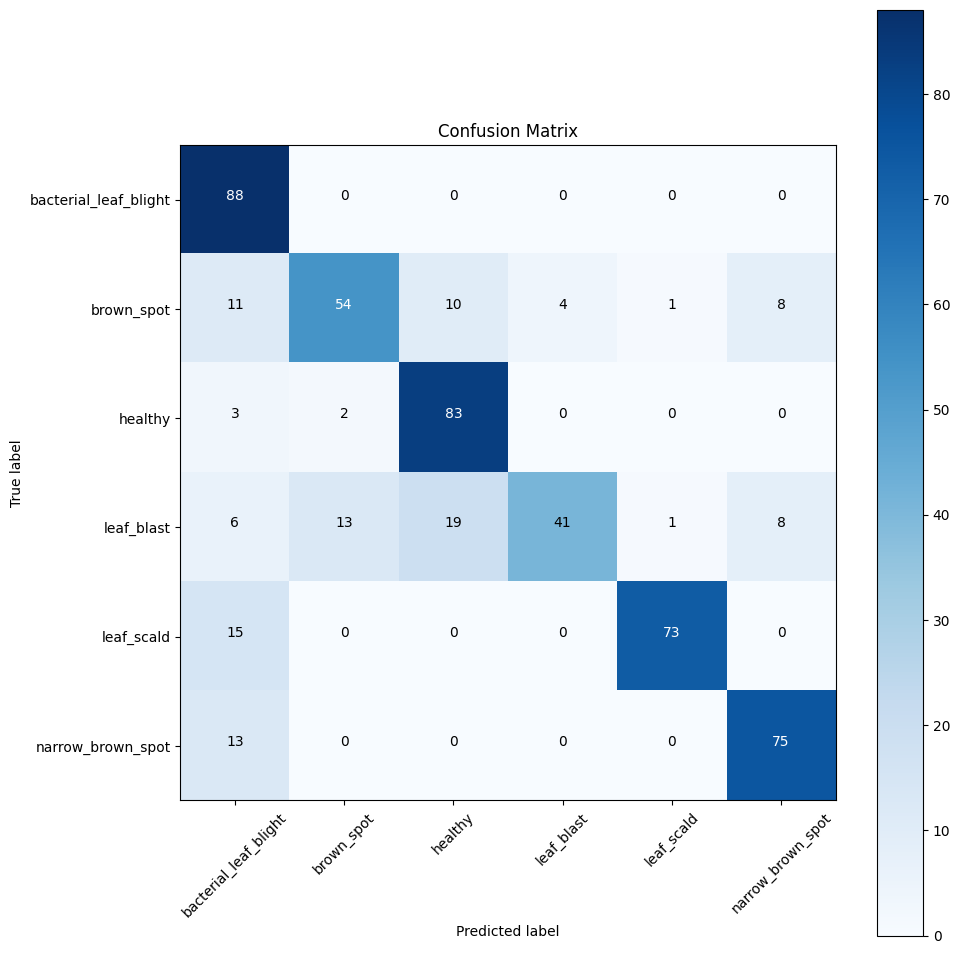

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

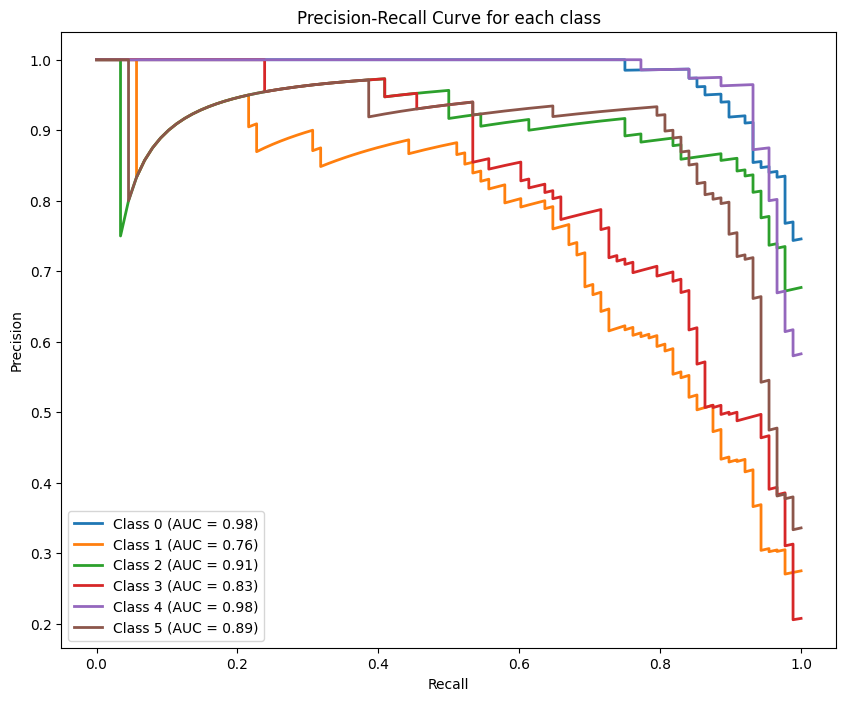

In [22]:
# Precision-Recall Curve for each class
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])
    
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

17/17 [==============================] - 18s 1s/step


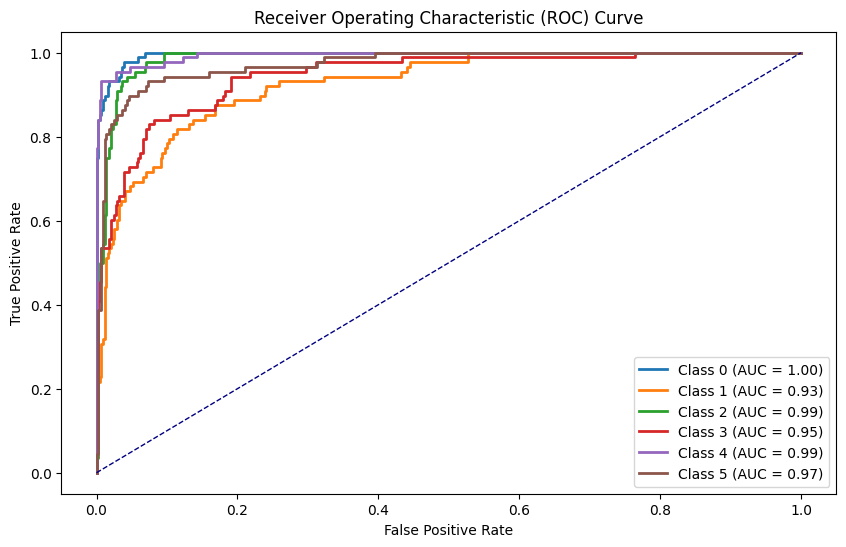

In [23]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

#Get the true labels from thee test generator
# y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

17/17 [==============================] - 18s 1s/step


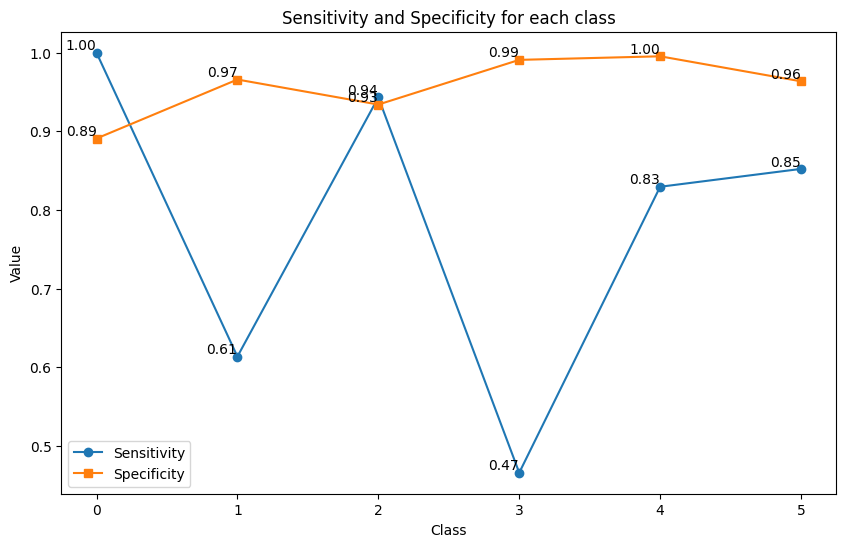

In [25]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Plot Sensitivity and Specificity for each class
plt.figure(figsize=(10, 6))
plt.plot(range(len(sensitivity_list)), sensitivity_list, marker='o', label='Sensitivity')
plt.plot(range(len(specificity_list)), specificity_list, marker='s', label='Specificity')
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('Sensitivity and Specificity for each class')
plt.legend()

# Add numeric labels
for i, (sensitivity, specificity) in enumerate(zip(sensitivity_list, specificity_list)):
    plt.text(i, sensitivity, f'{sensitivity:.2f}', ha='right', va='bottom')
    plt.text(i, specificity, f'{specificity:.2f}', ha='right', va='bottom')

plt.show()

In [ ]:
data = [['Bacterial_leaf_blight', 1.00, 0.85, 0.92],  
         ['Brown_spot', 0.56, 0.95, 0.70],  
         ['Leaf_smut', 0.89, 0.40, 0.55]]  
  
# 创建DataFrame  
df = pd.DataFrame(data, columns=['Classes', 'precision', 'recall', 'f1-score'])  
  
# 设置图形的宽度和位置  
N = len(df)  
ind = range(N)  
width = 0.3  # 条形图的宽度  
  
# 绘制precision的条形图  
precision_bars = plt.bar(ind, df['precision'], width, label='Precision')  
  
# 绘制recall的条形图，位置稍微偏移一点以便区分  
recall_bars = plt.bar([i + width for i in ind], df['recall'], width, label='Recall')  
  
# 绘制f1-score的条形图，再偏移一点  
f1_bars=plt.bar([i + width*2 for i in ind], df['f1-score'], width, label='F1-Score')  
  
# 添加类名到x轴  
plt.xticks([i + width*1.5 for i in ind], df['Classes'])  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Precision, Recall, and F1-Score per Class')  
  
# 添加图例  
plt.legend()  

# 为每个条形添加数字标签  
def add_value_labels(bars):  
    for bar in bars:  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width()/2, height,  
                 '{:.2f}'.format(height),  
                 ha='center', va='bottom')  
  
add_value_labels(precision_bars)
add_value_labels(recall_bars)
add_value_labels(f1_bars)

# 显示图形  
plt.show()

In [26]:
import visualkeras

visualkeras.layered_view(model,  legend=True)

AttributeError: 'FreeTypeFont' object has no attribute 'getsize'